We will perform text classificaiton using bag of words and finally load this as input into Fully connected layers of Neural Net. We shall use pandas,numpy for data operations and Keras for Fully connected layers of neural net

We will perform below steps
1. Clean Training data for punctuations and standard stopwords
2. Create vocab list 
3. Convert text to matrix usng Keras Tokenizer
4. Train neural net 
5. Predicton on test data and submission

In [58]:
# Load the libraries
import numpy as np
import pandas as pd

from pandas import DataFrame
from collections import Counter
from nltk.corpus import stopwords

from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from matplotlib import pyplot


In [7]:
# turn a text into clean tokens
def clean_text(text):
    # remove punctuation from the text
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?!')
    prods = set(text) & signs
    if not prods:
        return text
    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign) )
    # split into tokens by white space
    tokens = text.split()
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens


In [8]:
#Define column names
TEXT ="text"
AUTHOR = "author"

# Create fucntion to load words into vocab

def add_text_to_vocab(X_train, vocab):
    for text in X_Train[TEXT]:
      tokens = clean_text(text)
      # update counts
      vocab.update(tokens)
 

Now, we will load the training data, clean up each text and load create a vocab list after filtering on punctuations, stopwords,short length tokens and minimum occurance.

In [9]:
# Read text from training data
X_Train= pd.read_csv("train.csv")

# define vocab
vocab = Counter()

# add all text to vocab
add_text_to_vocab(X_Train,vocab)


In [10]:
# keep tokens with a min occurrence 
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]

Vocab list is now created. We will store that into a file for further reference

In [11]:
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

In [13]:
# load file into memory
def load_file(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# load the vocabulary back into memory to be used for model training
vocab_filename = 'vocab.txt'
vocab = load_file(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

Now, we can start data preparation for model training. We will use Keras Tokenizer with mode as 'freq', I have tried Binary, count and tfidf as well. Freq modes seems to work best with lowest loss among these options

In [14]:
# create the tokenizer
tokenizer = Tokenizer()

# prepare bag of words encoding of docs
def prepare_data(train_docs, mode):
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    return Xtrain


Now we will create neural network definition model with Keras. This will include multiple set of Dense, BatchNorm, Activation and dropout layer. You can decide on number of layers. 

Dropout is included in input latyer and hidden layers to reduce variance and overfitting on training data.

In [21]:
# Create a neural network model
def create_model(xtrain):
    
    X_input = Input(shape=(xtrain.shape[1],))
   
    # dropout on input layer
    X = Dropout(0.5)(X_input)
    
    # Dense -> BN -> RELU-> Dropout Block applied to X - First set
    X = Dense(900, kernel_initializer='he_normal', name='D0')(X)
    X = BatchNormalization(axis=1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    # Dense -> BN -> RELU-> Dropout Block applied to X - Second set
    X = Dense(600, kernel_initializer='he_normal', name='D1')(X)
    X = BatchNormalization(axis=1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    
    # Dense -> BN -> RELU-> Dropout Block applied to X - Third set
    X = Dense(300, kernel_initializer='he_normal', name='D2')(X)
    X = BatchNormalization(axis=1, name='bn2')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    # output layer with softmax function for 3 classes prediction
    X = Dense(3, kernel_initializer='he_normal', activation='softmax')(X)

    Spookymodel = Model(inputs=X_input, outputs=X, name='SpookyAuthor')
    
    return Spookymodel

We are ready to transform training data and create model

In [23]:
#Prepare data and and create model 
# You can try with other modes 'binary','count','tfidf'
modes = 'freq'

#Training 
train_texts = X_Train[TEXT]
# Training labels (coverted into seperate columsn for each other with 0,1)
ytrain = np.array(pd.get_dummies(X_Train[AUTHOR]))

# prepare data for mode
xtrain = prepare_data(train_texts, mode)

# model defination creation
Spookymodel = create_model(xtrain)
    

In [29]:
# Summarize the model
Spookymodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25944)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25944)             0         
_________________________________________________________________
D0 (Dense)                   (None, 900)               23350500  
_________________________________________________________________
bn0 (BatchNormalization)     (None, 900)               3600      
_________________________________________________________________
activation_4 (Activation)    (None, 900)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 900)               0         
_________________________________________________________________
D1 (Dense)                   (None, 600)               540600    
__________

Now we are ready to the model. Let's complie and train the model.

Optimizer - We will use "Adamax" optimizer with learning rate of 0.05 and rate decay of 0.001. You can tune these as per your preferences.

Loss function - Categorical_crossentropy.

Batch size - 64

validation split- 20%

Train on 15663 samples, validate on 3916 samples
Epoch 1/25
198s - loss: 0.3545 - acc: 0.8660 - val_loss: 0.4128 - val_acc: 0.8501
Epoch 2/25
196s - loss: 0.3650 - acc: 0.8659 - val_loss: 0.4121 - val_acc: 0.8501
Epoch 3/25
195s - loss: 0.3611 - acc: 0.8720 - val_loss: 0.4099 - val_acc: 0.8506
Epoch 4/25
226s - loss: 0.3668 - acc: 0.8703 - val_loss: 0.4098 - val_acc: 0.8519
Epoch 5/25
226s - loss: 0.3704 - acc: 0.8646 - val_loss: 0.4112 - val_acc: 0.8519
Epoch 6/25
225s - loss: 0.3623 - acc: 0.8682 - val_loss: 0.4134 - val_acc: 0.8493
Epoch 7/25
225s - loss: 0.3657 - acc: 0.8668 - val_loss: 0.4138 - val_acc: 0.8509
Epoch 8/25
225s - loss: 0.3564 - acc: 0.8659 - val_loss: 0.4100 - val_acc: 0.8532
Epoch 9/25
225s - loss: 0.3631 - acc: 0.8690 - val_loss: 0.4124 - val_acc: 0.8529
Epoch 10/25
225s - loss: 0.3678 - acc: 0.8682 - val_loss: 0.4165 - val_acc: 0.8506
Epoch 11/25
226s - loss: 0.3626 - acc: 0.8690 - val_loss: 0.4142 - val_acc: 0.8504
Epoch 12/25
226s - loss: 0.3578 - acc: 0.8720 -

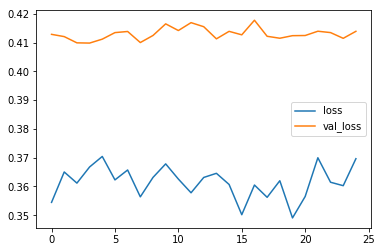

In [73]:
optimzer = optimizers.Adamax(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.001)

# compile network
Spookymodel.compile(loss='categorical_crossentropy', optimizer=optimzer, metrics=['accuracy'])

# fitnetwork
train_history = Spookymodel.fit(x= xtrain, y=ytrain, epochs=25,verbose=2,batch_size=32, validation_split=0.2)

# Plot the training and validation loss at each epoch
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
pyplot.plot(loss)
pyplot.plot(val_loss)
pyplot.legend(['loss', 'val_loss'])
pyplot.show()

Validation loss of 0.43 is achieved with 5 epochs. It can be minimized further with hyperparameter tunning and more training.

In [61]:
ConvNetmodel = Sequential()
ConvNetmodel.add(Conv1D(32, (3), padding='same',
                 input_shape=xtrain.shape[1:]))
ConvNetmodel.add(Activation('relu'))
ConvNetmodel.add(Conv1D(32, (3)))
ConvNetmodel.add(Activation('relu'))
ConvNetmodel.add(MaxPooling2D(pool_size=(2, 2)))
ConvNetmodel.add(Dropout(0.25))

ConvNetmodel.add(Conv1D(64, (3), padding='same'))
ConvNetmodel.add(Activation('relu'))
ConvNetmodel.add(Conv1D(64, (3)))
ConvNetmodel.add(Activation('relu'))
ConvNetmodel.add(MaxPooling2D(pool_size=(2, 2)))
ConvNetmodel.add(Dropout(0.25))

ConvNetmodel.add(Flatten())
ConvNetmodel.add(Dense(512))
ConvNetmodel.add(Activation('relu'))
ConvNetmodel.add(Dropout(0.5))
ConvNetmodel.add(Dense(3))
ConvNetmodel.add(Activation('softmax'))

ValueError: Input 0 is incompatible with layer conv1d_3: expected ndim=3, found ndim=2

In [74]:
#Prepare data and and create model 
# You can try with other modes 'binary','count','tfidf'
modes = 'freq'

#Training 
train_texts = X_Train[TEXT]
# Training labels (coverted into seperate columsn for each other with 0,1)
ytrain = np.array(pd.get_dummies(X_Train[AUTHOR]))

# prepare data for mode
xtrain = prepare_data(train_texts, mode)

# model defination creation
Spookymodel_ConvNet = ConvNet_model(xtrain)
    

ValueError: Input 0 is incompatible with layer zero_padding2d_4: expected ndim=4, found ndim=3

**Prediction on test data**

Now, we are ready to predict on test data and submit the results

In [36]:
# Function to predict the author class on test data
def predict_author(text, vocab,tokenizer, model):
    # clean
    tokens = clean_text(text)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='freq')
    # prediction
    yhat = model.predict(encoded, verbose=0)
    return yhat


In [75]:
# Load test data into dataframe
X_sub = pd.read_csv("test.csv")

# Initilize prediction matrix 
y_pred = np.zeros((X_sub.shape[0],3))

# Predict for each  sample in test dataset
i = 0
for text in X_sub[TEXT]:
    y_pred[i]=predict_author(text,vocab,tokenizer,Spookymodel)
    i +=1


In [76]:
#Creating submission datafram
submission = pd.DataFrame(y_pred,dtype=float)
submission=submission.rename(index=int, columns={0: "EAP", 1: "HPL", 2: "MWS"})
submission.insert(0,'id',X_sub["id"])


#Save as CSV file for submission
submission.to_csv("sub.csv",sep=',', encoding='utf-8')